---
title: Mean total precipitation from ERA5
author: Harsha R. Hampapura
date: "2026-1-20"
---

# Access ERA5 preciptation data from NCAR GDEX 

:::{important} Important Info for the Data
ERA5 data from ECMFW is also available on NCAR GDEX at https://gdex.ucar.edu/datasets/d633000/#
:::

## Required Packages
Please make sure to installed the packages before moving forward
- intake
- intake-esm >= 2025.7.9
- matplotlib
- xarray
- dask
- kerchunk
- cartopy

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr
import intake
import intake_esm
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client

## Step 1 - Locate the Dataset
On the NCAR GDEX portal, go to the `Data Access` tab for the ERA5 dataset to find the intake-ESM catalogs needed to access data. In this notebook we will use GDEX POSIX catalog.

In [13]:
# Please specify your preferred data access method: the Data URL or the GDEX POSIX path. 
era5_catalog_posix = '/gdex/data/d633000/catalogs/d633000-posix.json'
# era5_catalog_url = 'http://data.gdex.ucar.edu/d633000/catalogs/d633000-https.json'

## Step 2 - Set up cluster

In [4]:
# Set up your sratch folder path
username       = os.environ["USER"]
glade_scratch  = "/glade/derecho/scratch/" + username
print(glade_scratch)

/glade/derecho/scratch/harshah


In [8]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk25',
    cores = 1,
    memory = '8GiB',
    processes = 1,
    local_directory = glade_scratch+'/dask/spill/',
    log_directory = glade_scratch + '/dask/logs/',
    resource_spec = 'select=1:ncpus=1:mem=8GB',
    queue = 'casper',
    walltime = '5:00:00',
    interface = 'ext'
)

In [9]:
# Create the client to load the Dashboard
client = Client(cluster)

In [10]:
n_workers = 5
cluster.scale(n_workers)
client.wait_for_workers(n_workers = n_workers)
cluster

PBSCluster(7797a457, 'tcp://128.117.208.116:35697', workers=5, threads=5, memory=40.00 GiB)

## Step 3 - Open the catalog, find and load the variable of interest

In [14]:
%%time
era5_cat = intake.open_esm_datastore(era5_catalog_posix)
era5_cat

CPU times: user 7.15 ms, sys: 4.44 ms, total: 11.6 ms
Wall time: 32 ms


,unique
path,172
variable,173
format,2
short_name,173
long_name,172
units,28
start_time,1
end_time,2
level,0
level_units,0


In [15]:
era5_cat.df[['variable','long_name']].drop_duplicates()

,variable,long_name
0,VAR_100U,100 metre U wind component
1,VAR_100V,100 metre V wind component
2,VAR_10U,10 metre U wind component
3,VAR_10V,10 metre V wind component
4,VAR_2D,2 metre dewpoint temperature
...,...,...
192,VAR_10FG,10 metre wind gust since previous post-processing
193,MX2T,Maximum temperature at 2 metres since previous...
194,MXTPR,Maximum total precipitation rate since previou...
195,MN2T,Minimum temperature at 2 metres since previous...


In [16]:
cat_subset = era5_cat.search(variable='MTPR')
cat_subset.df

,path,variable,format,short_name,long_name,units,start_time,end_time,level,level_units,frequency
0,/glade/campaign/collections/gdex/data/d633000/...,MTPR,reference,mtpr,Mean total precipitation rate,kg m**-2 s**-1,NaN,NaN,NaN,NaN,NaN


In [17]:
%%time
dset_subset = cat_subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.short_name'


CPU times: user 982 ms, sys: 224 ms, total: 1.21 s
Wall time: 11.1 s


## Step 4 - Data Analysis 

In [18]:
mtpr = dset_subset['MTPR.mtpr']
mtpr

<xarray.Dataset> Size: 3TB
Dimensions:                (forecast_initial_time: 61666, forecast_hour: 12,
                            latitude: 721, longitude: 1440)
Coordinates:
  * forecast_hour          (forecast_hour) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * forecast_initial_time  (forecast_initial_time) datetime64[ns] 493kB 1940-...
  * latitude               (latitude) float64 6kB 90.0 89.75 ... -89.75 -90.0
  * longitude              (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
Data variables:
    MTPR                   (forecast_initial_time, forecast_hour, latitude, longitude) float32 3TB dask.array<chunksize=(1, 12, 721, 1440), meta=np.ndarray>
    utc_date               (forecast_initial_time) int32 247kB dask.array<chunksize=(1024,), meta=np.ndarray>
Attributes: (12/17)
    CONVERSION_DATE:                 Wed Nov  2 10:03:48 MDT 2022
    CONVERSION_PLATFORM:             Linux r3i0n28 4.12.14-95.51-default #1 S...
    Conventions:                     CF-1.6
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NCO:                             netCDF Operators version 5.0.3 (Homepage...
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    ...                              ...
    intake_esm_attrs:variable:       MTPR
    intake_esm_attrs:_data_format_:  reference
    intake_esm_attrs:short_name:     mtpr
    intake_esm_attrs:long_name:      Mean total precipitation rate
    intake_esm_attrs:units:          kg m**-2 s**-1
    intake_esm_dataset_key:          MTPR.mtpr

Plot mean total precipitation for a particular forecast_initial_time and forecast_hour

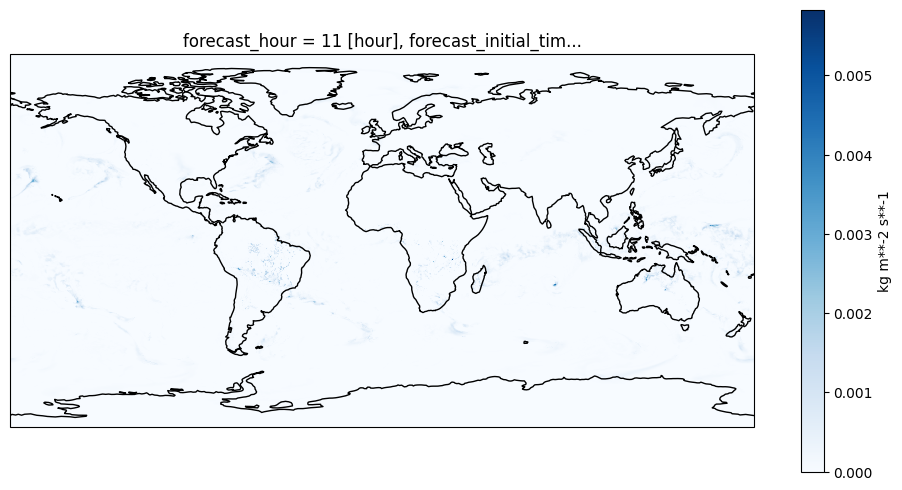

In [19]:
da = mtpr.MTPR.isel(forecast_hour=10).isel(forecast_initial_time=10)

# 2) Make a Cartopy map axis
proj = ccrs.PlateCarree()  
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": proj})

# 3) Plot onto that axis
im = da.plot(
    ax=ax,  
    transform=ccrs.PlateCarree(),
    cmap = 'Blues',
    x="longitude",
    y="latitude",
    #robust=True,                
    cbar_kwargs={"label": getattr(da, "units", "")},
)

ax.coastlines(color="black", linewidth=1.0)

In [20]:
# Close the cluster
cluster.close()